# OASIS AS_REQ DAM
OASIS AS_REQ Day Ahead Market Report(s)

## Download Data

#### To run this report, first downloaded the database into the same directory as this notebook, and unzip it.
See this page for the list of available reports and the download links:

https://github.com/energy-analytics-project/energy-dashboard/blob/master/docs/datasets.md

## Preview Data

#### Then check to see what tables are available using the command line and sqlite3

```bash
$ sqlite3 data-oasis-as-req-dam_00.db ".tables"


disclaimer_item  messagepayload   report_data      report_item    
messageheader    oasisreport      report_header    rto  
```

#### Look at table structure

```bash
$ sqlite3 data-oasis-as-req-dam_00.db ".tables" | sed 's/ /\n/g' | sed '/^\s*$/d'

disclaimer_item
messagepayload
report_data
report_item
messageheader
oasisreport
report_header
rto
```


```bash
$ sqlite3 data-oasis-as-req-dam_00.db ".tables" | sed 's/ /\n/g' | sed '/^\s*$/d' | xargs -L 1 -I {} sqlite3 data-oasis-as-req-dam_00.db "pragma table_info([{}]);"

0|disclaimer|TEXT|0||1
1|rto_name|TEXT|0||0

0|id|TEXT|0||1
1|oasisreport_id|TEXT|0||0

0|interval_num|INTEGER|0||1
1|interval_start_gmt|TEXT|0||2
2|resource_name|TEXT|0||3
3|interval_end_gmt|TEXT|0||4
4|opr_date|TEXT|0||5
5|value|INTEGER|0||6
6|data_item|TEXT|0||7
7|report_item_id|TEXT|0||0

0|id|TEXT|0||1
1|rto_name|TEXT|0||0
0|timedate|TEXT|0||1
1|source|TEXT|0||2
2|version|TEXT|0||3
3|oasisreport_id|TEXT|0||0

0|id|TEXT|0||1

0|report|TEXT|0||1
1|system|TEXT|0||2
2|uom|TEXT|0||3
3|mkt_type|TEXT|0||5
4|sec_per_interval|INTEGER|0||4
5|interval|TEXT|0||6
6|tz|TEXT|0||7
7|report_item_id|TEXT|0||0

0|name|TEXT|0||1
1|messagepayload_id|TEXT|0||0
```

So it's clear that report_data, report_header, and report_item are the important tables here.

## Load Data

In [54]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from pandasql import sqldf

# Create the connection to the unzipped database
cnx  = sqlite3.connect(r'./data-oasis-as-req-dam_00.db')

## Preview the schema

In [55]:
for table in ['disclaimer_item','messagepayload','report_data','report_item','messageheader','oasisreport','report_header','rto']:      
    print("--------------------------------------------------")
    print("table: %s" % table)
    print("--------------------------------------------------")
    for row in cnx.execute("PRAGMA table_info([%s]);" % table):
         print(row)

--------------------------------------------------
table: disclaimer_item
--------------------------------------------------
(0, 'disclaimer', 'TEXT', 0, None, 1)
(1, 'rto_name', 'TEXT', 0, None, 0)
--------------------------------------------------
table: messagepayload
--------------------------------------------------
(0, 'id', 'TEXT', 0, None, 1)
(1, 'oasisreport_id', 'TEXT', 0, None, 0)
--------------------------------------------------
table: report_data
--------------------------------------------------
(0, 'interval_num', 'INTEGER', 0, None, 1)
(1, 'interval_start_gmt', 'TEXT', 0, None, 2)
(2, 'resource_name', 'TEXT', 0, None, 3)
(3, 'interval_end_gmt', 'TEXT', 0, None, 4)
(4, 'opr_date', 'TEXT', 0, None, 5)
(5, 'value', 'INTEGER', 0, None, 6)
(6, 'data_item', 'TEXT', 0, None, 7)
(7, 'report_item_id', 'TEXT', 0, None, 0)
--------------------------------------------------
table: report_item
--------------------------------------------------
(0, 'id', 'TEXT', 0, None, 1)
(1, 'rto

## Select Data

In [56]:
df = pd.read_sql("select report_data.data_item, report_data.value, report_header.uom, report_header.report, report_header.mkt_type, report_data.interval_start_gmt, report_data.interval_end_gmt from report_header inner join report_data on report_header.report_item_id = report_data.report_item_id;", cnx)
df[0:5]

,data_item,value,uom,report,mkt_type,interval_start_gmt,interval_end_gmt
0,NS_REQ_MAX_MW,0,MW,AS_REQ,DAM,2013-08-26T07:00:00-00:00,2013-08-26T08:00:00-00:00
1,NS_REQ_MAX_MW,0,MW,AS_REQ,DAM,2013-08-26T08:00:00-00:00,2013-08-26T09:00:00-00:00
2,NS_REQ_MAX_MW,0,MW,AS_REQ,DAM,2013-08-26T09:00:00-00:00,2013-08-26T10:00:00-00:00
3,NS_REQ_MAX_MW,0,MW,AS_REQ,DAM,2013-08-26T10:00:00-00:00,2013-08-26T11:00:00-00:00
4,NS_REQ_MAX_MW,0,MW,AS_REQ,DAM,2013-08-26T11:00:00-00:00,2013-08-26T12:00:00-00:00


## Reports

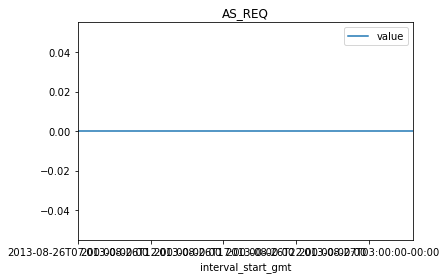

In [57]:
for title, group in df.groupby(['report']):
    group.plot.line(x='interval_start_gmt', y='value', title=title)

## Errors

This is showing that there is a pipeline error. All the report_data.value records for this report are '0', which is clearly not the case. When this sort of thing happens, it's useful to drop back into Sqlite3 and verify the database
directly:

```bash
$ sqlite3 data-oasis-as-req-dam_00.db 
SQLite version 3.28.0 2019-04-16 19:49:53
Enter ".help" for usage hints.
sqlite> select report_data.data_item, report_data.value, report_header.uom, report_header.report, report_header.mkt_type, report_data.interval_start_gmt, report_data.interval_end_gmt from report_header inner join report_data on report_header.report_item_id = report_data.report_item_id limit 10;
NS_REQ_MAX_MW|0|MW|AS_REQ|DAM|2013-08-26T07:00:00-00:00|2013-08-26T08:00:00-00:00
NS_REQ_MAX_MW|0|MW|AS_REQ|DAM|2013-08-26T08:00:00-00:00|2013-08-26T09:00:00-00:00
NS_REQ_MAX_MW|0|MW|AS_REQ|DAM|2013-08-26T09:00:00-00:00|2013-08-26T10:00:00-00:00
NS_REQ_MAX_MW|0|MW|AS_REQ|DAM|2013-08-26T10:00:00-00:00|2013-08-26T11:00:00-00:00
NS_REQ_MAX_MW|0|MW|AS_REQ|DAM|2013-08-26T11:00:00-00:00|2013-08-26T12:00:00-00:00
NS_REQ_MAX_MW|0|MW|AS_REQ|DAM|2013-08-26T12:00:00-00:00|2013-08-26T13:00:00-00:00
NS_REQ_MAX_MW|0|MW|AS_REQ|DAM|2013-08-26T13:00:00-00:00|2013-08-26T14:00:00-00:00
NS_REQ_MAX_MW|0|MW|AS_REQ|DAM|2013-08-26T14:00:00-00:00|2013-08-26T15:00:00-00:00
NS_REQ_MAX_MW|0|MW|AS_REQ|DAM|2013-08-26T15:00:00-00:00|2013-08-26T16:00:00-00:00
NS_REQ_MAX_MW|0|MW|AS_REQ|DAM|2013-08-26T16:00:00-00:00|2013-08-26T17:00:00-00:00

sqlite> select report_data.data_item, report_data.value, report_header.uom, report_header.report, report_header.mkt_type, report_data.interval_start_gmt, report_data.interval_end_gmt from report_header inner join report_data on report_header.report_item_id = report_data.report_item_id where report_data.value > 0 limit 10;

```

So direct verification with the db shows that all values are zero.

BUG: fix the data-oasis-as-req-dam_00.db feed.

Today is Sept 30 and this will be my top issue for this afternoon. I'll detail how I diagnose this issue in this report for future adopters to trouble shoot problems as they arise.